In [655]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [656]:
%pip install fastf1

Note: you may need to restart the kernel to use updated packages.


In [657]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [658]:
import fastf1
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import stats
#--
import fastf1

fastf1.Cache.enable_cache('f1_cache')

#2
session = fastf1.get_session(2023, 'Monza', 'R')
session.load()

core           INFO 	Loading data for Italian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 06:25.888000 before the recorded end of the session.
core        WARNING 	Driver 11 completed the race distance 06:19.824000 before the recorded end of the session.
core        WAR

In [659]:
laps = session.laps
laps.head()
laps.columns


Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

In [660]:
# Import the modules
from preprocessing import preprocess_laps
from validate_preprocessing import validate_preprocessing, plot_preprocessing_diagnostics
# Save original data for comparison (optional but recommended)
original_laps = laps.copy()
# Run preprocessing
laps = preprocess_laps(laps)

Step 1: Handling missing values
  Removed 10 rows

Step 2: Removing outliers
  Removed 15 outliers, preserved 51 pit laps

Step 3: Converting timedelta to seconds
  Converted 3 columns

Step 4: Encoding categorical variables
  Created 21 features

Step 5: Scaling features
  Scaled 5 features

Preprocessing complete
Final dataset: 933 laps, 61 features
                    Time Driver DriverNumber                LapTime  \
0 0 days 01:23:49.780000    VER            1 0 days 00:01:27.905000   
1 0 days 01:25:15.943000    VER            1 0 days 00:01:26.163000   
2 0 days 01:26:41.645000    VER            1 0 days 00:01:25.702000   
3 0 days 01:28:07.695000    VER            1 0 days 00:01:26.050000   
4 0 days 01:29:33.871000    VER            1 0 days 00:01:26.176000   

   LapNumber  Stint PitOutTime PitInTime            Sector1Time  \
0        1.0    1.0        NaT       NaT                    NaT   
1        2.0    1.0        NaT       NaT 0 days 00:00:28.274000   
2        3.0    1.

DATA QUALITY VALIDATION REPORT

1. MISSING VALUES CHECK
------------------------------------------------------------
No missing values in critical columns

2. OUTLIER CHECK (LapTimeSeconds)
------------------------------------------------------------

3. TYPE CONVERSION CHECK
------------------------------------------------------------
All time columns converted to numeric (seconds)

4. CATEGORICAL ENCODING CHECK
------------------------------------------------------------
  Compound encoded features: 2
  Driver encoded features: 19
✓ Categorical variables encoded successfully

5. FEATURE SCALING CHECK
------------------------------------------------------------
  Scaled features: 5
✓ Scaling applied correctly (mean ≈ 0, std ≈ 1)

6. DATA DISTRIBUTION SUMMARY
------------------------------------------------------------
  Total laps: 933
  Total features: 61
  Unique drivers: 19
  Unique compounds: 2

  LapTimeSeconds statistics:
    Mean: 87.671s
    Median: 87.025s
    Std Dev: 3.538s

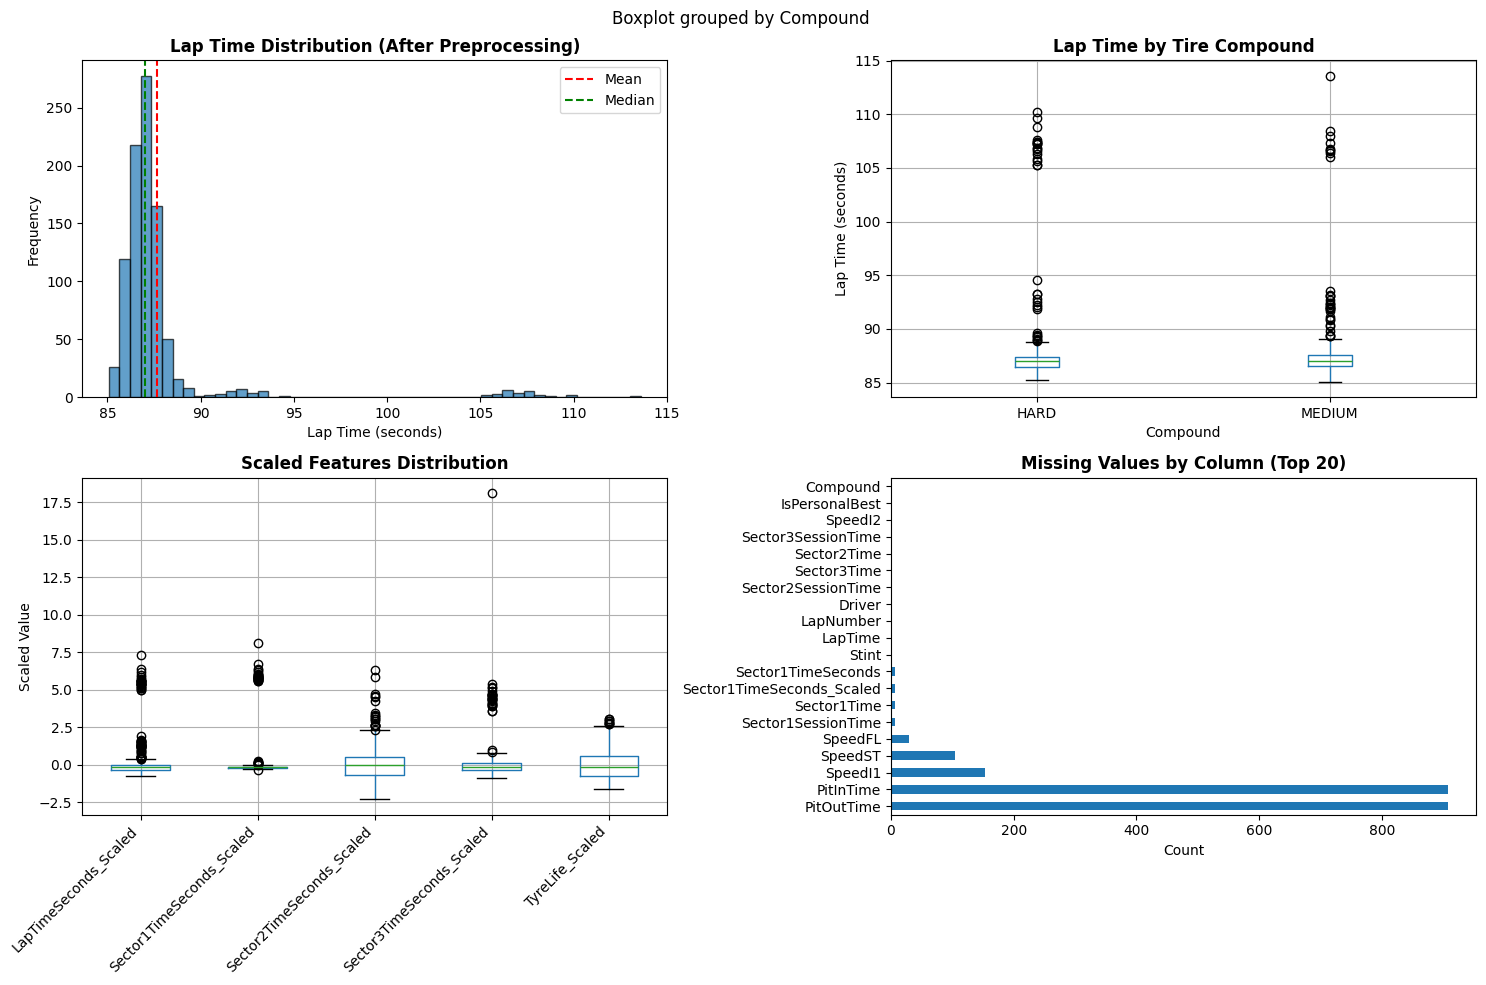

In [661]:
# Validate the preprocessed data
validation_results = validate_preprocessing(laps, original_laps)

# Show diagnostic plots
plot_preprocessing_diagnostics(laps)

Lap Time Distribution (Top Left): The small "bump" on the far right (105s+) proves that it successfully preserved the Pit Stops.

Tire Physics (Top Right): The "Medium" tire box is slightly lower (faster) than the "Hard" tire box. This confirms data reflects real-world physics.

Scaled Features (Bottom Left): All data is centered around 0. This means te normalization worked, which is critical for the stability.

Missing Values (Bottom Right): Drivers only pit once or twice a race; the empty values represent the 50+ laps of normal racing.

#Preparation and Logic

In [662]:
print(laps.head())

                    Time Driver DriverNumber                LapTime  \
0 0 days 01:23:49.780000    VER            1 0 days 00:01:27.905000   
1 0 days 01:25:15.943000    VER            1 0 days 00:01:26.163000   
2 0 days 01:26:41.645000    VER            1 0 days 00:01:25.702000   
3 0 days 01:28:07.695000    VER            1 0 days 00:01:26.050000   
4 0 days 01:29:33.871000    VER            1 0 days 00:01:26.176000   

   LapNumber  Stint PitOutTime PitInTime            Sector1Time  \
0        1.0    1.0        NaT       NaT                    NaT   
1        2.0    1.0        NaT       NaT 0 days 00:00:28.274000   
2        3.0    1.0        NaT       NaT 0 days 00:00:28.097000   
3        4.0    1.0        NaT       NaT 0 days 00:00:28.145000   
4        5.0    1.0        NaT       NaT 0 days 00:00:28.155000   

             Sector2Time  ... Driver_SAI Driver_SAR Driver_STR Driver_VER  \
0 0 days 00:00:29.666000  ...        0.0        0.0        0.0        1.0   
1 0 days 00:00:2

In [663]:
print(laps[['Driver', 'LapNumber', 'LapTime', 'TyreLife', 'Compound']].head(40))

   Driver  LapNumber                LapTime  TyreLife Compound
0     VER        1.0 0 days 00:01:27.905000       1.0   MEDIUM
1     VER        2.0 0 days 00:01:26.163000       2.0   MEDIUM
2     VER        3.0 0 days 00:01:25.702000       3.0   MEDIUM
3     VER        4.0 0 days 00:01:26.050000       4.0   MEDIUM
4     VER        5.0 0 days 00:01:26.176000       5.0   MEDIUM
5     VER        6.0 0 days 00:01:26.837000       6.0   MEDIUM
6     VER        7.0 0 days 00:01:26.368000       7.0   MEDIUM
7     VER        8.0 0 days 00:01:25.990000       8.0   MEDIUM
8     VER        9.0 0 days 00:01:26.605000       9.0   MEDIUM
9     VER       10.0 0 days 00:01:26.603000      10.0   MEDIUM
10    VER       11.0 0 days 00:01:26.643000      11.0   MEDIUM
11    VER       12.0 0 days 00:01:26.442000      12.0   MEDIUM
12    VER       13.0 0 days 00:01:26.666000      13.0   MEDIUM
13    VER       14.0 0 days 00:01:27.028000      14.0   MEDIUM
14    VER       15.0 0 days 00:01:26.782000      15.0  

In [664]:
'''
Calculating Pitloss
Here we compare green flag lap time vs the Pit in and out lap times
'''
# Filter for drivers who finished, doing this removes crash data (drivers who crashed during the race)
clean_laps = laps.pick_quicklaps() # Removes slow laps ( like Yellow flags)
avg_race_pace = clean_laps['LapTimeSeconds'].median()

In [665]:
#Identify Pit Laps
pit_laps = laps[laps['PitOutTime'].notna()] # Laps where they exited the pits
avg_pit_lap_time = pit_laps['LapTimeSeconds'].median()

In [666]:
# Estimating PIt loss
pit_loss = avg_pit_lap_time - avg_race_pace

print(f"Avg Race Pace: {avg_race_pace} seconds")

print(f"Avg Pit lap Time: {avg_pit_lap_time} seconds")

print(f"Estimated Pit loss: {pit_loss} seconds")

Avg Race Pace: 86.968 seconds
Avg Pit lap Time: 107.237 seconds
Estimated Pit loss: 20.26899999999999 seconds


# Modeling Tire Degradation (how much slower a car gets per lap)

In [667]:
#Making a tire degradation function
#Rival bot, Later, the goal is to beat this bot.

import random

class RaceParameters:
    base_lap_time = 87
    pit_loss = 21.00
def get_tire_degradation(tire_age, compound='medium'):
    if compound == 'soft':
        deg = 0.15 * tire_age
        if tire_age > 15: deg += 0.5 * (tire_age - 15)
    elif compound == 'medium':
        deg = 0.08 * tire_age
        if tire_age > 25: deg += 0.4 * (tire_age - 25)
    elif compound == 'hard':
        deg = 0.05 * tire_age
        if tire_age > 35: deg += 0.3 * (tire_age - 35)
    else:
        raise ValueError(f"Unknown compound: {compound}")
    return deg

class RivalBot:
    def __init__(self, pit_lap=24, start_tire='medium', switch_tire='hard'):
        self.pit_lap = pit_lap
        self.current_tire = start_tire
        self.switch_tire = switch_tire
        self.tire_age = 0

    def get_action(self, current_lap):
        if current_lap == self.pit_lap:
            self.current_tire = self.switch_tire
            self.tire_age = 0
            return 1  # Pit
        
        self.tire_age += 1
        return 0  # Stay Out


#Environment Design

In [668]:
%pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


In [669]:
import gymnasium as gym
from gymnasium import spaces

In [670]:
class F1PitStopEnv(gym.Env):
    metadata = {'render_modes': ['console']}

    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(4)  # 0=Stay, 1=Soft, 2=Med, 3=Hard
        self.observation_space = spaces.Box(
            low=np.zeros(4, dtype=np.float32),
            high=np.ones(4, dtype=np.float32),
            dtype=np.float32
        )
        self.total_laps = 51
        self.pit_loss_seconds = 20.30

        # State
        self.current_lap = 0
        self.current_tire_age = 0
        self.current_compound = 0  # 0=Soft, 1=Medium, 2=Hard
        self.gap_to_rival = 0.0
        self.agent_total_time = 0.0
        self.num_stops = 0
        self.compounds_used = set()
        self.rival_total_time = 0.0

    def _get_obs(self):
        norm_lap = self.current_lap / self.total_laps
        norm_age = self.current_tire_age / self.total_laps
        norm_compound = self.current_compound / 2.0
        norm_gap = np.clip((self.gap_to_rival + 120) / 240, 0.0, 1.0)
        return np.array([norm_lap, norm_age, norm_compound, norm_gap], dtype=np.float32)

    def get_valid_actions(self):

        valid = [0]  # "Stay out" is always valid

        # Can only pit if: lap >= 10, haven't pitted yet, and not in last 5 laps
        if self.current_lap >= 10 and self.num_stops == 0 and self.current_lap <= 45:
            # Can pit for any compound DIFFERENT from current
            for action in [1, 2, 3]:
                target_compound = action - 1
                if target_compound != self.current_compound:
                    valid.append(action)

        return valid

    def _calculate_lap_time(self):
        base_lap_time = 86.5
        degradation = 0.0
        if self.current_compound == 0:  # Soft
            degradation = 0.05 * self.current_tire_age
            if self.current_tire_age > 16:
                degradation += 0.4 * (self.current_tire_age - 16)
        elif self.current_compound == 1:  # Medium
            degradation = 0.03 * self.current_tire_age
            if self.current_tire_age > 26:
                degradation += 0.2 * (self.current_tire_age - 26)
        elif self.current_compound == 2:  # Hard
            degradation = 0.015 * self.current_tire_age
        return base_lap_time + degradation

    def _get_rival_time_at_lap(self, lap):
        """Rival: Medium -> Hard, pits on Lap 22."""
        base = 87
        total = 0.0
        for i in range(lap):
            if i < 22:
                total += base + 0.03 * i
            elif i == 22:
                total += base + self.pit_loss_seconds
            else:
                total += base + 0.015 * (i - 22)
        return total

    def step(self, action):
        terminated = False
        truncated = False
        info = {}
        reward = 0.0

        valid_actions = self.get_valid_actions()
        if action not in valid_actions:
            action = 0

        # Process action
        if action in [1, 2, 3]:
            new_compound = action - 1
            self.current_compound = new_compound
            self.compounds_used.add(new_compound)
            self.current_tire_age = 0
            self.num_stops += 1

        # Calculate lap time
        lap_time = self._calculate_lap_time()
        if action in [1, 2, 3]:
            lap_time += self.pit_loss_seconds

        self.agent_total_time += lap_time

        # REWARD = negative lap time (agent minimizes total race time)
        reward = -lap_time

        # Advance
        self.current_lap += 1
        self.current_tire_age += 1

        # Update gap
        rival_cumulative = self._get_rival_time_at_lap(self.current_lap)
        self.gap_to_rival = rival_cumulative - self.agent_total_time

        # Terminal
        if self.current_lap >= self.total_laps:
            terminated = True
            final_rival = self.rival_total_time if self.rival_total_time > 0 else rival_cumulative

            if len(self.compounds_used) < 2:
                reward -= 5000
                info['outcome'] = 'Disqualified (1 Compound)'
            elif self.agent_total_time < final_rival:
                reward += 100
                info['outcome'] = 'Win'
            else:
                reward -= 100
                info['outcome'] = 'Loss'

        return self._get_obs(), reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_lap = 0
        self.current_tire_age = 0
        self.current_compound = 0  # Start on Softs
        self.gap_to_rival = 0.0
        self.agent_total_time = 0.0
        self.num_stops = 0
        self.compounds_used = {self.current_compound}
        self.rival_total_time = self._get_rival_time_at_lap(self.total_laps)
        return self._get_obs(), {}

    def render(self):
        print(f"Lap {self.current_lap} | Tire: {['S','M','H'][self.current_compound]} "
              f"age {self.current_tire_age} | Gap: {self.gap_to_rival:+.1f}s")


# Q-Learning Algorithm (A reinforcement learning algorithm where an agent learns to make the best decisions (optimal policy) by trial-and-error, without needing a map of its environment)

In [671]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.5, discount_factor=1.0,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.999):
        self.env = env

        # State: Lap(52) x TireAge(52) x Compound(3) x HasPitted(2) x Actions(4)
        q_shape = (52, 52, 3, 2, env.action_space.n)
        self.q_table = np.full(q_shape, -10000.0)

        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

    def _discretize(self, obs, num_stops):
        lap = max(0, min(51, int(round(obs[0] * 51))))
        age = max(0, min(51, int(round(obs[1] * 51))))
        compound = max(0, min(2, int(round(obs[2] * 2))))
        has_pitted = min(num_stops, 1)  # 0 or 1
        return (lap, age, compound, has_pitted)

    def choose_action(self, state, valid_actions):
        if np.random.random() < self.epsilon:
            # Random exploration — but only among valid actions
            return np.random.choice(valid_actions)
        else:

            q_values = self.q_table[state]
            valid_q = {a: q_values[a] for a in valid_actions}
            max_q = max(valid_q.values())
            best_actions = [a for a, q in valid_q.items() if q == max_q]
            return np.random.choice(best_actions)

    def update(self, state, action, reward, next_state, terminated, next_valid_actions):
        current_q = self.q_table[state][action]
        if terminated:
            target = reward
        else:
            # Only consider Q-values of VALID next actions
            next_q_values = [self.q_table[next_state][a] for a in next_valid_actions]
            target = reward + self.gamma * max(next_q_values)
        self.q_table[state][action] += self.lr * (target - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

In [672]:
def train(env, agent, num_episodes=10000):
    rewards_history = []
    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = agent._discretize(obs, env.num_stops)
        total_reward = 0
        terminated = False

        while not terminated:
            valid_actions = env.get_valid_actions()
            action = agent.choose_action(state, valid_actions)
            next_obs, reward, terminated, _, info = env.step(action)
            next_state = agent._discretize(next_obs, env.num_stops)
            next_valid = env.get_valid_actions()
            agent.update(state, action, reward, next_state, terminated, next_valid)
            state = next_state
            total_reward += reward

        agent.decay_epsilon()
        rewards_history.append(total_reward)

        if (episode + 1) % 2000 == 0:
            avg = np.mean(rewards_history[-500:])
            print(f"Episode {episode+1} | Avg Reward: {avg:.1f} | Epsilon: {agent.epsilon:.4f}")

    return rewards_history

def run_test_episodes(env, agent, num_episodes=100):
    results = []
    for _ in range(num_episodes):
        obs, _ = env.reset()
        state = agent._discretize(obs, env.num_stops)
        terminated = False
        pit_laps = []
        compounds_sequence = ['Soft']
        lap = 0
        total_reward = 0

        while not terminated:
            valid_actions = env.get_valid_actions()
            # Greedy: pick best valid action
            q_values = agent.q_table[state]
            valid_q = {a: q_values[a] for a in valid_actions}
            max_q = max(valid_q.values())
            best_actions = [a for a, q in valid_q.items() if q == max_q]
            action = np.random.choice(best_actions)

            obs, reward, terminated, _, info = env.step(action)
            state = agent._discretize(obs, env.num_stops)
            if action in [1, 2, 3]:
                pit_laps.append(lap)
                compounds_sequence.append(['Soft', 'Medium', 'Hard'][action - 1])
            total_reward += reward
            lap += 1

        results.append({
            'total_reward': total_reward,
            'pit_laps': pit_laps,
            'compounds_sequence': compounds_sequence,
            'outcome': info.get('outcome', 'Unknown'),
            'agent_time': env.agent_total_time,
            'rival_time': env.rival_total_time
        })
    return results


In [673]:
env = F1PitStopEnv()
agent = QLearningAgent(env)
rewards = train(env, agent, num_episodes=10000)

Episode 2000 | Avg Reward: -4361.2 | Epsilon: 0.1352
Episode 4000 | Avg Reward: -4348.3 | Epsilon: 0.0183
Episode 6000 | Avg Reward: -4347.3 | Epsilon: 0.0100
Episode 8000 | Avg Reward: -4346.4 | Epsilon: 0.0100
Episode 10000 | Avg Reward: -4346.8 | Epsilon: 0.0100


#Model and Agent Validation

In [674]:
import matplotlib.pyplot as plt
from collections import Counter


##run 100 test races

In [675]:
print(type(env))
print(type(agent))
print(len(rewards))

<class '__main__.F1PitStopEnv'>
<class '__main__.QLearningAgent'>
10000


In [676]:
results = run_test_episodes(env, agent, num_episodes=100)
RIVAL_PIT_LAP = 20  # The rival's known pit lap


##Test 1 Undercut detection

In [677]:
print(f"Rival pits on Lap {RIVAL_PIT_LAP}. Agent should pit BEFORE that.\n")

first_pit_laps = [r['pit_laps'][0] for r in results if len(r['pit_laps']) > 0]

if first_pit_laps:
    pit_counts = Counter(first_pit_laps)
    mode_lap = pit_counts.most_common(1)[0][0]
    avg_lap = np.mean(first_pit_laps)

    print(f"Mode (most frequent) pit lap: {mode_lap}")
    print(f"Average first pit lap:        {avg_lap:.1f}")
    print(f"Distribution: {dict(sorted(pit_counts.items()))}")

    if mode_lap < RIVAL_PIT_LAP:
        print("\nPASS — Agent undercuts the rival!")
    else:
        print(f"\nFAIL — Mode pit lap ({mode_lap}) is NOT before rival ({RIVAL_PIT_LAP})")

    # Over-eager check
    if mode_lap < 15:
        print(f"!!!! Agent pits very early (lap {mode_lap}).")
        print("Risk of running out of tire life at the end of the race.")
else:
    print("fAIL, the agent never pitted")



Rival pits on Lap 20. Agent should pit BEFORE that.

Mode (most frequent) pit lap: 10
Average first pit lap:        10.0
Distribution: {10: 100}

PASS — Agent undercuts the rival!
!!!! Agent pits very early (lap 10).
Risk of running out of tire life at the end of the race.


## Follow the rules

In [678]:
print("The -500 penalty must act as an 'electric fence'.\n")

dq_count = sum(1 for r in results if 'Disqualified' in r['outcome'])
dq_rate = dq_count / len(results) * 100

print(f"Disqualifications: {dq_count}/{len(results)} ({dq_rate:.0f}%)")

if dq_count == 0:
    print("\nPASS — 0% disqualification rate")
else:
    print(f"\nFAIL — {dq_rate:.0f}% disqualification rate")
    print("If this persists after 5,000+ episodes, increase")
    print("the penalty from -500 to -1000, or verify compounds_used")
    print("state is being correctly tracked.")


The -500 penalty must act as an 'electric fence'.

Disqualifications: 0/100 (0%)

PASS — 0% disqualification rate


## Compound Selection

In [679]:
print("Agent should avoid Soft→Soft (same compound) and find a")
print("sensible sequence like S→M, S→H, or M→H.\n")

strategy_counts = Counter()
for r in results:
    seq = ' → '.join(r['compounds_sequence'])
    strategy_counts[seq] += 1

print("Strategy frequency (top 5):")
for strategy, count in strategy_counts.most_common(5):
    pct = count / len(results) * 100
    print(f"  {strategy}: {count}x ({pct:.0f}%)")


illegal_count = 0
for r in results:
    seq = r['compounds_sequence']
    for i in range(1, len(seq)):
        if seq[i] == seq[i-1]:
            illegal_count += 1
            break

if illegal_count == 0:
    print("\nNo same-compound transitions detected")
else:
    print(f"\n{illegal_count} races had same-compound transitions")

# Note about S→H
top_strategy = strategy_counts.most_common(1)[0][0] if strategy_counts else ""
if 'Hard' in top_strategy and 'Medium' not in top_strategy:
    print("ℹAgent prefers S→H: prioritizing durability over pace for stint 2")


Agent should avoid Soft→Soft (same compound) and find a
sensible sequence like S→M, S→H, or M→H.

Strategy frequency (top 5):
  Soft → Hard: 100x (100%)

No same-compound transitions detected
ℹAgent prefers S→H: prioritizing durability over pace for stint 2


## Training Stability

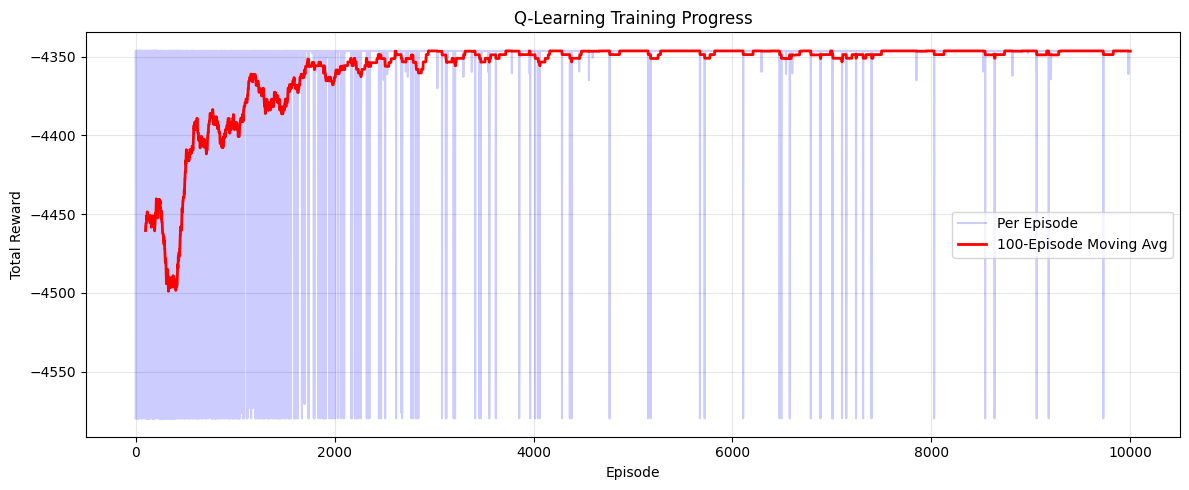


Early avg reward (first 500):  -4461.5
Mid avg reward (middle 500):   -4347.8
Late avg reward (last 500):    -4346.8

PASS — Curve has plateaued. Training is stable.


In [680]:
fig, ax = plt.subplots(figsize=(12, 5))

# Raw rewards (faded)
ax.plot(rewards, alpha=0.2, color='blue', label='Per Episode')

# Moving average (bold)
window = 100
if len(rewards) >= window:
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax.plot(range(window-1, len(rewards)), moving_avg, color='red',
            linewidth=2, label=f'{window}-Episode Moving Avg')

ax.set_xlabel('Episode')
ax.set_ylabel('Total Reward')
ax.set_title('Q-Learning Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


early_avg = np.mean(rewards[:500])
late_avg = np.mean(rewards[-500:])
mid_avg = np.mean(rewards[len(rewards)//2 - 250 : len(rewards)//2 + 250])

print(f"\nEarly avg reward (first 500):  {early_avg:.1f}")
print(f"Mid avg reward (middle 500):   {mid_avg:.1f}")
print(f"Late avg reward (last 500):    {late_avg:.1f}")

# Check if still climbing or plateaued
if late_avg > mid_avg + 5:
    print("\nCurve is STILL climbing — agent hasn't finished learning.")
    print("   Consider training for more episodes (e.g., 10,000).")
elif late_avg > early_avg:
    print("\nPASS — Curve has plateaued. Training is stable.")
else:
    print("\nFAIL — No improvement detected. Check hyperparameters.")



## Check Winrate

In [681]:
wins = sum(1 for r in results if r['outcome'] == 'Win')
losses = sum(1 for r in results if r['outcome'] == 'Loss')
dqs = sum(1 for r in results if 'Disqualified' in r['outcome'])
win_rate = wins / len(results) * 100

print(f"\nWins: {wins} | Losses: {losses} | DQs: {dqs}")
print(f"Win Rate: {win_rate:.0f}%")

if win_rate == 100:
    print("\nPASS — 100% win rate!")
elif win_rate >= 80:
    print(f"\nPASS — {win_rate:.0f}% win rate (≥80% threshold)")
elif win_rate >= 50:
    print(f"\nPARTIAL — {win_rate:.0f}% win rate (below 80%)")
else:
    print(f"\nFAIL — {win_rate:.0f}% win rate. Agent loses more than it wins.")



Wins: 100 | Losses: 0 | DQs: 0
Win Rate: 100%

PASS — 100% win rate!


In [682]:

print("\n" + "=" * 60)
print("FINAL PHASE 4 SUMMARY")
avg_agent = np.mean([r['agent_time'] for r in results])
avg_rival = np.mean([r['rival_time'] for r in results])
print(f"Avg Agent Race Time:  {avg_agent:.1f}s")
print(f"Avg Rival Race Time:  {avg_rival:.1f}s")
print(f"Avg Time Advantage:   {avg_rival - avg_agent:+.1f}s")
print(f"Win Rate:             {win_rate:.0f}%")
print(f"Disqualification Rate: {dq_rate:.0f}%")
if first_pit_laps:
    print(f"Mode Pit Lap:         {mode_lap} (Rival: {RIVAL_PIT_LAP})")



FINAL PHASE 4 SUMMARY
Avg Agent Race Time:  4446.3s
Avg Rival Race Time:  4470.3s
Avg Time Advantage:   +24.0s
Win Rate:             100%
Disqualification Rate: 0%
Mode Pit Lap:         10 (Rival: 20)
